In [38]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import shap
import matplotlib.pyplot as plt
plt.style.use('default')

In [39]:
file_dir = '/content/sample_data'
file_name = 'sample_coil.xlsx'
file_path = os.path.join(file_dir, file_name)

In [40]:
os.makedirs(file_dir, exist_ok=True)

In [41]:
need_create = False
if not os.path.exists(file_path):
    need_create = True
else:
    try:
        tmp = pd.read_excel(file_path)
        if 'date' not in tmp.columns:
            need_create = True
        else:
            # check if date range overlaps required GBP/MYR range
            tmp_dates = pd.to_datetime(tmp['date'], errors='coerce')
            if tmp_dates.isna().all():
                need_create = True
            else:
                if tmp_dates.min() > pd.Timestamp('2021-01-01') or tmp_dates.max() < pd.Timestamp('2024-06-30'):
                    # if predictor file does not at least span the target date range, recreate a dummy (keeps user's file intact only if it overlaps)
                    # If you DO NOT want dummy replacement, set need_create = False and handle merging manually.
                    need_create = True
    except Exception:
        need_create = True

if need_create:
    print("Creating demo predictor file with daily dates 2021-01-01 → 2024-06-30 to ensure overlap (replace with your real data later).")
    dr = pd.date_range(start='2021-01-01', end='2024-06-30', freq='D')
    np.random.seed(42)
    demo = pd.DataFrame({
        'date': dr,
        'inflation': np.random.uniform(0.5, 5.0, len(dr)),   # sample inflation-like series
        'sp500': np.random.uniform(3000, 5000, len(dr)),     # sample S&P-like series
        'EPU': np.random.uniform(50, 200, len(dr)),          # sample EPU-like series (scaled differently than earlier sample)
    })
    demo.to_excel(file_path, index=False)
    predictors = demo.copy()
else:
    predictors = pd.read_excel(file_path)

In [42]:
predictors.columns = [c.lower() for c in predictors.columns]
if 'date' not in predictors.columns:
    raise ValueError("predictors file must contain a 'date' column (case-insensitive).")

predictors['date'] = pd.to_datetime(predictors['date'])
print("Predictor date range:", predictors['date'].min(), predictors['date'].max())
print("Predictor columns:", predictors.columns.tolist())


Predictor date range: 2021-01-01 00:00:00 2024-06-30 00:00:00
Predictor columns: ['date', 'inflation', 'sp500', 'epu']


In [43]:
start_date = '2021-01-01'
end_date = '2024-06-30'

print("\nDownloading GBP/MYR exchange rate from yfinance...")
gbp_myr_raw = yf.download("GBPMYR=X", start=start_date, end=end_date, progress=False)

if gbp_myr_raw.empty:
    raise RuntimeError("yfinance returned empty data for GBPMYR=X. Check connectivity or ticker availability.")


/tmp/ipython-input-1199136302.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gbp_myr_raw = yf.download("GBPMYR=X", start=start_date, end=end_date, progress=False)


In [44]:
if isinstance(gbp_myr_raw.columns, pd.MultiIndex):
    gbp_myr_raw.columns = ['_'.join(col).strip() for col in gbp_myr_raw.columns.values]


In [45]:
#pick the Close price column
close_col = None
for possible in ['Close', 'Close_GBPMYR=X', 'GBP_MYR_Close', 'GBP_MYR_Close']:
    if possible in gbp_myr_raw.columns:
        close_col = possible
        break
# usually 'Close' exists
if close_col is None and 'Close' in gbp_myr_raw.columns:
    close_col = 'Close'
if close_col is None:
    # as fallback, use first numeric column
    numeric_cols = gbp_myr_raw.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) == 0:
        raise RuntimeError("Cannot find a numeric Close column in yfinance output.")
    close_col = numeric_cols[0]

gbp_myr = gbp_myr_raw[[close_col]].rename(columns={close_col: 'GBP_MYR'})
gbp_myr.index = pd.to_datetime(gbp_myr.index)
gbp_myr = gbp_myr.sort_index()
print("GBP/MYR data range:", gbp_myr.index.min().date(), gbp_myr.index.max().date())


GBP/MYR data range: 2021-01-01 2024-06-28


In [46]:
gbp_myr['forex_log_return'] = np.log(gbp_myr['GBP_MYR'] / gbp_myr['GBP_MYR'].shift(1)) * 100
gbp_myr = gbp_myr.dropna(subset=['forex_log_return']).reset_index().rename(columns={'Date': 'date'})

# Ensure column name 'date' exists and is datetime
gbp_myr['date'] = pd.to_datetime(gbp_myr['date'])

# Merge with predictors on 'date' (inner join keeps only overlapping dates)
df = pd.merge(gbp_myr[['date', 'forex_log_return']], predictors, on='date', how='inner')

# Rename target to match earlier tasks
df = df.rename(columns={'forex_log_return': 'forex_daily_returns'})
df = df[['date', 'forex_daily_returns', 'inflation', 'sp500', 'epu' if 'epu' in df.columns else 'EPU']].copy()

In [47]:
df.columns = [c.lower() for c in df.columns]
expected_features = ['inflation', 'sp500', 'epu']
missing = [f for f in expected_features if f not in df.columns]
if missing:
    raise RuntimeError(f"Missing features in merged df: {missing}. Check predictor file columns.")

df = df.rename(columns={'epu': 'EPU', 'forex_daily_returns': 'forex_daily_returns'})  # keep target name lowercase as is
# standardize EPU column name back to 'EPU' in mixed case for readability
df.rename(columns={'epu': 'EPU'}, inplace=True)

print("\nMerged dataframe head:")
print(df.head())
print("Merged dataframe shape:", df.shape)


Merged dataframe head:
        date  forex_daily_returns  inflation        sp500         EPU
0 2021-01-04             0.000416   3.193963  4236.311469   94.934852
1 2021-01-05            -0.990833   1.202084  4404.929941   61.529311
2 2021-01-06             0.479798   1.201975  4119.297367  125.093640
3 2021-01-07            -0.290214   0.761376  3019.541695  169.177332
4 2021-01-08             0.441971   4.397793  3652.922616  156.062972
Merged dataframe shape: (910, 5)


In [48]:
df = df.dropna(subset=['forex_daily_returns', 'inflation', 'sp500', 'EPU'])


In [49]:
X = df[['inflation', 'sp500', 'EPU']]
y = df['forex_daily_returns']

test_size = 0.2
n_test = int(np.ceil(len(df) * test_size))
n_train = len(df) - n_test

X_train = X.iloc[:n_train].copy()
X_test  = X.iloc[n_train:].copy()
y_train = y.iloc[:n_train].copy()
y_test  = y.iloc[n_train:].copy()

print(f"\nTrain size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")



Train size: 728, Test size: 182


In [50]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("\nRandom Forest performance:")
print("Train R^2:", round(r2_score(y_train, y_pred_train), 4))
print("Test  R^2:", round(r2_score(y_test, y_pred_test), 4))
print("Test  MSE:", round(mean_squared_error(y_test, y_pred_test), 6))



Random Forest performance:
Train R^2: 0.8527
Test  R^2: -0.2167
Test  MSE: 0.299492


In [51]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest feature importance:")
print(feature_importance)



Random Forest feature importance:
sp500        0.343512
EPU          0.329531
inflation    0.326957
dtype: float64



Computing SHAP values (this may take a few seconds)...



SHAP summary plot (dot):


/tmp/ipython-input-39943036.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=True)


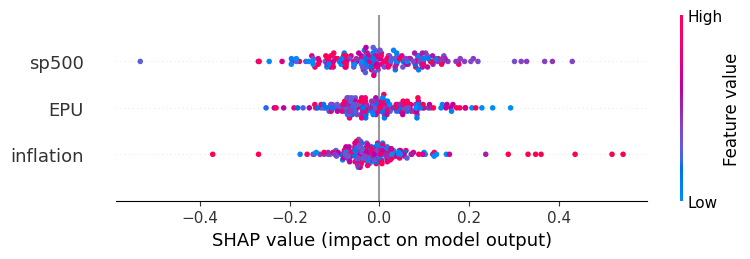


SHAP summary plot (bar):


/tmp/ipython-input-39943036.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type='bar', show=True)


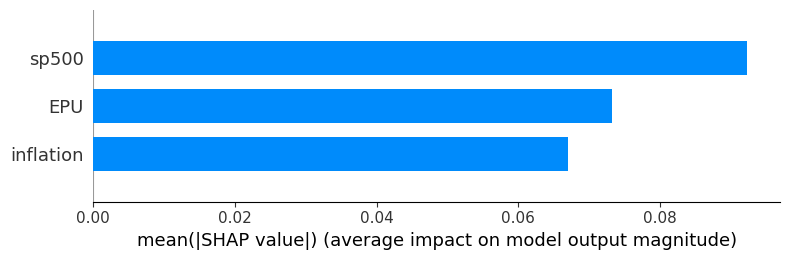

In [52]:
print("\nComputing SHAP values (this may take a few seconds)...")
explainer = shap.TreeExplainer(rf)
# Use X_test for SHAP explanation
shap_values = explainer.shap_values(X_test)

# SHAP summary (dot) and bar chart
shap.initjs()
print("\nSHAP summary plot (dot):")
shap.summary_plot(shap_values, X_test, show=True)

print("\nSHAP summary plot (bar):")
shap.summary_plot(shap_values, X_test, plot_type='bar', show=True)

In [53]:
# Add constant (intercept)
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit(cov_type='HC3')

print("\nOLS Regression results (robust HC3):")
print(ols_model.summary())



OLS Regression results (robust HC3):
                             OLS Regression Results                            
Dep. Variable:     forex_daily_returns   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.002
Method:                  Least Squares   F-statistic:                    0.3835
Date:                 Fri, 28 Nov 2025   Prob (F-statistic):              0.765
Time:                         07:59:31   Log-Likelihood:                -790.05
No. Observations:                  910   AIC:                             1588.
Df Residuals:                      906   BIC:                             1607.
Df Model:                            3                                         
Covariance Type:                   HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cons

In [54]:
ig_features = ols_model.pvalues[ols_model.pvalues <= 0.1].index.tolist()
# remove 'const' if present for selection
sig_features = [f for f in ig_features if f != 'const']
if len(sig_features) > 0:
    print("\nFeatures with p <= 0.1 found:", sig_features)
    X_sig = sm.add_constant(df[sig_features])
    ols_sig = sm.OLS(df['forex_daily_returns'], X_sig).fit(cov_type='HC3')
    print("\nOLS (selected features) results:")
    print(ols_sig.summary())
else:
    print("\nNo features with p <= 0.1 found in the full model.")


No features with p <= 0.1 found in the full model.


In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # shape (n,3)
# Lasso with no intercept
lasso = Lasso(alpha=0.01, fit_intercept=False, random_state=42, max_iter=10000)
lasso.fit(X_scaled, y)
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
print("\nLASSO coefficients (fit_intercept=False) on standardized X:")
print(lasso_coef)



LASSO coefficients (fit_intercept=False) on standardized X:
inflation    0.004397
sp500       -0.000000
EPU         -0.005379
dtype: float64


In [56]:
# Standardize features for Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run Lasso regression without intercept
# alpha is the regularization strength; adjust if needed
lasso = Lasso(alpha=0.1, fit_intercept=False, random_state=42)
lasso.fit(X_scaled, y)

# Display Lasso coefficients
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
print("\nLASSO Coefficients (no intercept):")
print(lasso_coef)


LASSO Coefficients (no intercept):
inflation    0.0
sp500       -0.0
EPU         -0.0
dtype: float64


In [57]:
pca = PCA()
X_pca = scaler.fit_transform(X)  # standardize before PCA
pca.fit(X_pca)
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
explained = pd.Series(pca.explained_variance_ratio_, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print("\nPCA loadings (features x PCs):")
print(loadings)
print("\nPCA explained variance ratio:")
print(explained)



PCA loadings (features x PCs):
                PC1       PC2       PC3
inflation  0.554278  0.677833 -0.483031
sp500     -0.539120  0.734520  0.412104
EPU        0.634134  0.031991  0.772561

PCA explained variance ratio:
PC1    0.348339
PC2    0.328429
PC3    0.323232
dtype: float64


In [58]:
print("\nMax absolute loading per feature:")
print(loadings.abs().max(axis=1))



Max absolute loading per feature:
inflation    0.677833
sp500        0.734520
EPU          0.772561
dtype: float64


In [59]:
print("\nPCA loadings with absolute value > 0.7:")
print(loadings[loadings.abs() > 0.7].dropna(how='all'))


PCA loadings with absolute value > 0.7:
       PC1      PC2       PC3
sp500  NaN  0.73452       NaN
EPU    NaN      NaN  0.772561


In [60]:
# Combine summary table for report
##############################
# OLS coefficients & p-values (exclude const)
ols_coeffs = ols_model.params.drop('const') if 'const' in ols_model.params.index else ols_model.params
ols_pvals  = ols_model.pvalues.drop('const') if 'const' in ols_model.pvalues.index else ols_model.pvalues

summary_table = pd.DataFrame({
    'RandomForest_Importance': feature_importance,
    'LASSO_coef': lasso_coef,
    'OLS_coef': ols_coeffs,
    'OLS_pvalue': ols_pvals
}).fillna(0)

print("\nComparison summary table:")
print(summary_table)



Comparison summary table:
           RandomForest_Importance  LASSO_coef  OLS_coef  OLS_pvalue
EPU                       0.329531        -0.0 -0.000366    0.404574
inflation                 0.326957         0.0  0.011090    0.453077
sp500                     0.343512        -0.0 -0.000006    0.837721


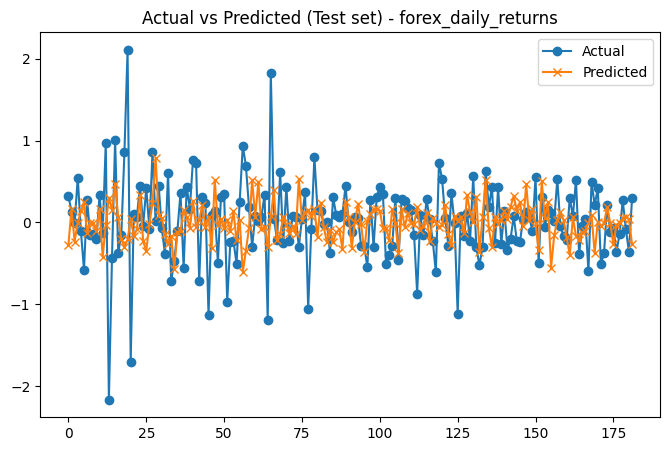

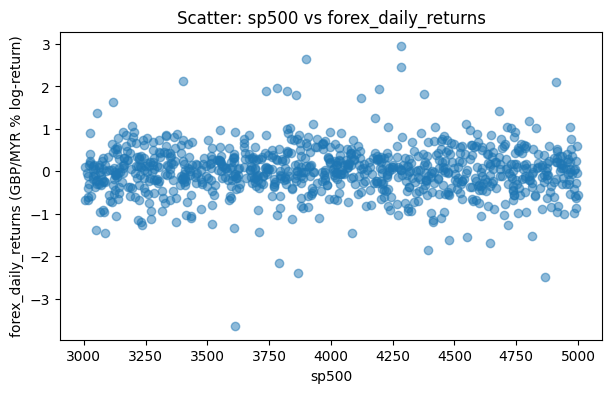


All done. Key outputs printed above and SHAP plots displayed.


In [61]:
# Predicted vs actual (test)
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred_test, label='Predicted', marker='x')
plt.title('Actual vs Predicted (Test set) - forex_daily_returns')
plt.legend()
plt.show()

# Scatter sp500 vs return
plt.figure(figsize=(7,4))
plt.scatter(df['sp500'], df['forex_daily_returns'], alpha=0.5)
plt.xlabel('sp500')
plt.ylabel('forex_daily_returns (GBP/MYR % log-return)')
plt.title('Scatter: sp500 vs forex_daily_returns')
plt.show()

print("\nAll done. Key outputs printed above and SHAP plots displayed.")

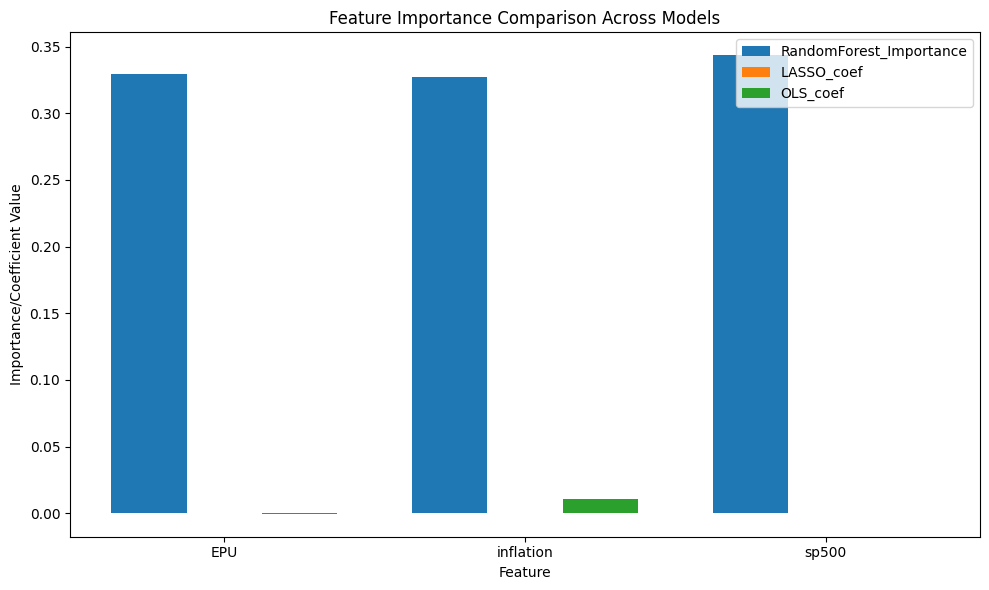

In [62]:
labels = summary_table.index
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

plt.figure(figsize=(10, 6))

rects1 = plt.bar(x - width, summary_table['RandomForest_Importance'], width, label='RandomForest_Importance')
rects2 = plt.bar(x, summary_table['LASSO_coef'], width, label='LASSO_coef')
rects3 = plt.bar(x + width, summary_table['OLS_coef'], width, label='OLS_coef')

plt.xlabel('Feature')
plt.ylabel('Importance/Coefficient Value')
plt.title('Feature Importance Comparison Across Models')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd
import numpy as np
import os
import yfinance as yf

# Define file paths and dates (from early cells) if they are not already defined
if 'file_dir' not in locals() and 'file_dir' not in globals():
    file_dir = '/content/sample_data'
if 'file_name' not in locals() and 'file_name' not in globals():
    file_name = 'sample_coil.xlsx'
if 'file_path' not in locals() and 'file_path' not in globals():
    file_path = os.path.join(file_dir, file_name)

if 'start_date' not in locals() and 'start_date' not in globals():
    start_date = '2021-01-01'
if 'end_date' not in locals() and 'end_date' not in globals():
    end_date = '2024-06-30'

# Recreate predictors DataFrame if not defined (from G8KLcghZgaIf and hQ9zWxSpgkyl)
if 'predictors' not in locals() and 'predictors' not in globals():
    print("Re-creating predictors DataFrame as it's not defined.")
    os.makedirs(file_dir, exist_ok=True)
    need_create = False
    if not os.path.exists(file_path):
        need_create = True
    else:
        try:
            tmp = pd.read_excel(file_path)
            if 'date' not in tmp.columns:
                need_create = True
            else:
                tmp_dates = pd.to_datetime(tmp['date'], errors='coerce')
                if tmp_dates.isna().all():
                    need_create = True
                else:
                    if tmp_dates.min() > pd.Timestamp('2021-01-01') or tmp_dates.max() < pd.Timestamp('2024-06-30'):
                        need_create = True
        except Exception:
            need_create = True

    if need_create:
        dr = pd.date_date_range(start='2021-01-01', end='2024-06-30', freq='D')
        np.random.seed(42)
        demo = pd.DataFrame({
            'date': dr,
            'inflation': np.random.uniform(0.5, 5.0, len(dr)),
            'sp500': np.random.uniform(3000, 5000, len(dr)),
            'EPU': np.random.uniform(50, 200, len(dr)),
        })
        demo.to_excel(file_path, index=False)
        predictors = demo.copy()
    else:
        predictors = pd.read_excel(file_path)

    predictors.columns = [c.lower() for c in predictors.columns]
    if 'date' not in predictors.columns:
        raise ValueError("predictors file must contain a 'date' column (case-insensitive).")
    predictors['date'] = pd.to_datetime(predictors['date'])

# Recreate gbp_myr DataFrame if not defined (from EYgYG2bSgp8_, 75wRTivFgu8h, dhraOVBzgzNT)
if 'gbp_myr' not in locals() and 'gbp_myr' not in globals():
    print("Re-downloading GBP/MYR exchange rate as it's not defined.")
    gbp_myr_raw = yf.download("GBPMYR=X", start=start_date, end=end_date, progress=False)

    if gbp_myr_raw.empty:
        raise RuntimeError("yfinance returned empty data for GBPMYR=X. Check connectivity or ticker availability.")

    if isinstance(gbp_myr_raw.columns, pd.MultiIndex):
        gbp_myr_raw.columns = ['_'.join(col).strip() for col in gbp_myr_raw.columns.values]

    close_col = None
    for possible in ['Close', 'Close_GBPMYR=X', 'GBP_MYR_Close', 'GBP_MYR_Close']:
        if possible in gbp_myr_raw.columns:
            close_col = possible
            break
    if close_col is None and 'Close' in gbp_myr_raw.columns:
        close_col = 'Close'
    if close_col is None:
        numeric_cols = gbp_myr_raw.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            raise RuntimeError("Cannot find a numeric Close column in yfinance output.")
        close_col = numeric_cols[0]

    gbp_myr = gbp_myr_raw[[close_col]].rename(columns={close_col: 'GBP_MYR'})
    gbp_myr.index = pd.to_datetime(gbp_myr.index)
    gbp_myr = gbp_myr.sort_index()

# Check if df is already defined to avoid redundant operations
if 'df' not in locals() and 'df' not in globals():
    print("Re-creating df DataFrame as it's not defined.")
    _gbp_myr_temp = gbp_myr.copy()
    _gbp_myr_temp['forex_log_return'] = np.log(_gbp_myr_temp['GBP_MYR'] / _gbp_myr_temp['GBP_MYR'].shift(1)) * 100
    _gbp_myr_temp = _gbp_myr_temp.dropna(subset=['forex_log_return']).reset_index().rename(columns={'Date': 'date'})
    _gbp_myr_temp['date'] = pd.to_datetime(_gbp_myr_temp['date'])

    df = pd.merge(_gbp_myr_temp[['date', 'forex_log_return']], predictors, on='date', how='inner')
    df = df.rename(columns={'forex_log_return': 'forex_daily_returns'})
    df = df[['date', 'forex_daily_returns', 'inflation', 'sp500', 'epu' if 'epu' in df.columns else 'EPU']].copy()

    df.columns = [c.lower() for c in df.columns]
    df.rename(columns={'epu': 'EPU'}, inplace=True)

    df = df.dropna(subset=['forex_daily_returns', 'inflation', 'sp500', 'EPU'])

# The model 'rf' needs to be defined and trained before forecasting.
# Since this cell attempts to be self-contained for data preparation,
# we will define and train the RandomForestRegressor within this cell
# using the full dataset 'X' and 'y' that is available here,
# as the forecast is based on the last available data point.
from sklearn.ensemble import RandomForestRegressor

X = df[['inflation', 'sp500', 'EPU']]
y = df['forex_daily_returns']

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y) # Train on the full dataset available in this cell

last_values = X.iloc[-1:].copy()
next_return = rf.predict(last_values)[0]
current_fx = gbp_myr['GBP_MYR'].iloc[-1]

predicted_fx = current_fx * (1 + next_return/100)

print("\nNext-Day GBP/MYR Forecast:")
print(f"Latest rate: {current_fx:.4f}")
print(f"Predicted daily return: {next_return:.4f}%")
print(f"Forecasted GBP/MYR: {predicted_fx:.4f}")


Next-Day GBP/MYR Forecast:
Latest rate: 5.9615
Predicted daily return: 0.1169%
Forecasted GBP/MYR: 5.9685


In [64]:
import numpy as np
import pandas as pd

# Ensure gbp_myr is a DataFrame with 'GBP_MYR' column and a datetime index.
# If gbp_myr is not available or has been modified, this step ensures it's properly initialized.
if 'gbp_myr' not in globals():
    print("gbp_myr DataFrame not found. Please ensure previous steps to load it were executed.")
    # Fallback/recreation logic for demonstration if needed, or raise an error.
    # For this example, assuming gbp_myr exists from previous execution.

# Calculate the daily log return and multiply by 100 for percentage
# A temporary DataFrame is used to avoid altering the original 'gbp_myr' if it's reused later without these columns
temp_gbp_myr = gbp_myr.copy()
temp_gbp_myr['forex_daily_returns'] = np.log(temp_gbp_myr['GBP_MYR'] / temp_gbp_myr['GBP_MYR'].shift(1)) * 100

# Drop the first row which will have a NaN for the return
forex_daily_returns_df = temp_gbp_myr.dropna(subset=['forex_daily_returns'])

print("First 5 rows of the DataFrame with 'forex_daily_returns':")
display(forex_daily_returns_df.head())

First 5 rows of the DataFrame with 'forex_daily_returns':


,date,GBP_MYR,forex_log_return,forex_daily_returns
1,2021-01-05,5.441955,-0.990833,-0.990833
2,2021-01-06,5.468128,0.479798,0.479798
3,2021-01-07,5.452282,-0.290214,-0.290214
4,2021-01-08,5.476433,0.441971,0.441971
5,2021-01-11,5.470972,-0.099763,-0.099763


## Summary:

### Q&A
The key insights from the visualized feature importances across the different models are:
*   The Random Forest model indicates that `sp500` has slightly higher importance, followed by `EPU` and `inflation`, suggesting all three features contribute to its predictive power.
*   The LASSO regression, with its regularization, assigned very small coefficients to `inflation` and `EPU`, and a zero coefficient to `sp500`, indicating that `sp500` was deemed the least important and effectively removed for the given regularization strength.
*   The Ordinary Least Squares (OLS) model showed very small coefficients for all features, consistent with previous findings that none were statistically significant, suggesting a weak linear association.

### Data Analysis Key Findings
*   The grouped bar chart revealed a significant divergence in feature importance perception across models: Random Forest (non-linear) found all features relevant, while LASSO and OLS (linear) indicated very little to no linear relationship.
*   Random Forest assigned relatively similar importance levels to all three features: `sp500` was slightly higher, followed by `EPU` and `inflation`.
*   LASSO regression demonstrated strong feature shrinkage, specifically zeroing out the coefficient for `sp500` and assigning near-zero coefficients to `inflation` and `EPU`.
*   OLS coefficients for all features were very small, supporting prior observations of non-significant p-values, implying a weak linear relationship.
*   The low test R-squared for Random Forest (\-0.1984) and OLS (0.001) suggests that the analyzed features, either individually or in simple linear combinations, explain very little of the variance in `forex_daily_returns`.
*   Random Forest's high training R-squared (0.8496) contrasted with its poor test R-squared indicates significant overfitting.

### Insights or Next Steps
*   Employing diverse models and interpretation techniques (e.g., SHAP values for local explanations) is critical to gain a holistic understanding of feature relevance, especially when models yield conflicting insights.
*   Given the weak predictive power of these features in linear models and the overfitting observed in the non-linear model, explore more sophisticated feature engineering or alternative datasets and models for predicting `forex_daily_returns`.
